In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# para la convolucional
#X = np.load('InpactorDB_non-redundant+negative.fasta.filtered_center.npy').astype(np.int8)
#Y = pd.read_csv('InpactorDB_non-redundant+negative.fasta.kmers')
#Y = Y.drop(['Label'], axis=1).values

# para la FNN
X = pd.read_csv('InpactorDB_non-redundant+negative.fasta.complementary')
X = np.array(X.drop(['Label'], axis=1).values, dtype=np.int8)
Y = pd.read_csv('InpactorDB_non-redundant+negative.fasta.kmers')
Y = Y.drop(['Label'], axis=1).values

In [4]:
print(X.shape)
print(Y.shape)

type(X[0, 0])

(102128, 29450)
(102128, 5460)


numpy.int8

In [5]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(81702, 29450)
(81702, 5460)
(10213, 29450)
(10213, 5460)
(10213, 29450)
(10213, 5460)


In [6]:
X = None
Y = None
path_log_base = './logs_CNN'

In [7]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [8]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [9]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, Y_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def TERL():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 3), strides= (1, 4))(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 3), strides= (1, 4))(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 3), strides= (1, 4))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(10000,activation="relu")(layers)
    #layers = tf.keras.layers.Dense(1000,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(7500,activation="relu")(layers)
    #layers = tf.keras.layers.Dropout(0.05)(layers)
    #layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(5460, activation="relu", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

In [14]:
def InpactorFNN_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(3000,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(inputs)
    #layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(3000,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    #layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(3000,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    #layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(5460, activation="relu", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29450)]           0         
_________________________________________________________________
dense (Dense)                (None, 3000)              88353000  
_________________________________________________________________
batch_normalization (BatchNo (None, 3000)              9000      
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9003000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3000)              9000      
_________________________________________________________________
dense_2 (Dense)              (None, 3000)              9003000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 3000)              9000  

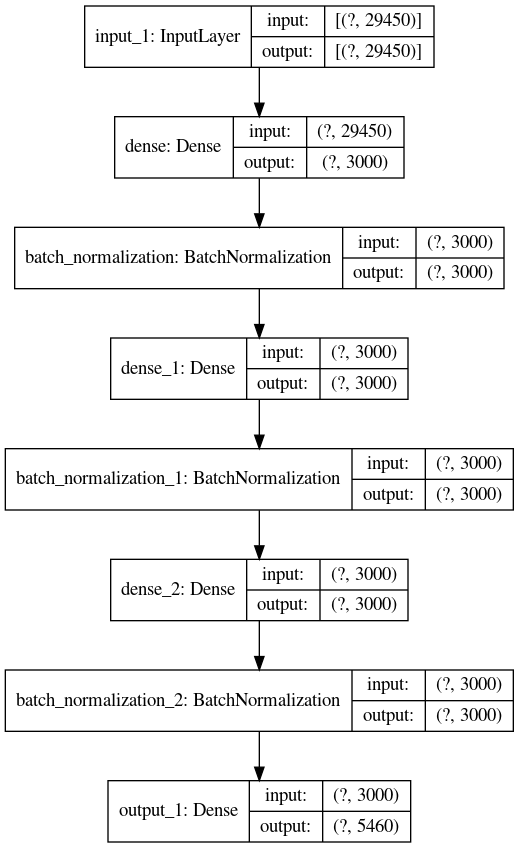

In [15]:
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
#one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=5460)
#one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=5460)
#one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=5460)

# Fit the model
epochs = 100
train(model, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, 64, epochs, "TERL")
Final_Results_Test(log_Dir) 

Epoch 1/100
1277/1277 [==============================] - 51s 40ms/step - loss: 382507.0000 - f1_m: 0.7631 - val_loss: 346929.1562 - val_f1_m: 0.7634
Epoch 2/100
1277/1277 [==============================] - 50s 39ms/step - loss: 345342.8750 - f1_m: 0.7618 - val_loss: 342875.0938 - val_f1_m: 0.7153
Epoch 3/100
1277/1277 [==============================] - 50s 39ms/step - loss: 346934.6250 - f1_m: 0.6932 - val_loss: 344267.4062 - val_f1_m: 0.6752
Epoch 4/100
1277/1277 [==============================] - 50s 39ms/step - loss: 348120.1562 - f1_m: 0.6540 - val_loss: 346115.2188 - val_f1_m: 0.6392
Epoch 5/100
1277/1277 [==============================] - 50s 39ms/step - loss: 348431.1562 - f1_m: 0.6361 - val_loss: 345613.4688 - val_f1_m: 0.6353
Epoch 6/100
1277/1277 [==============================] - 50s 39ms/step - loss: 347710.1562 - f1_m: 0.6367 - val_loss: 345174.9375 - val_f1_m: 0.6392
Epoch 7/100
1277/1277 [==============================] - 50s 39ms/step - loss: 346702.5000 - f1_m: 0.6438 

Epoch 56/100
1277/1277 [==============================] - 51s 40ms/step - loss: 323862.2812 - f1_m: 0.8398 - val_loss: 323981.4688 - val_f1_m: 0.8342
Epoch 57/100
1277/1277 [==============================] - 51s 40ms/step - loss: 323786.2500 - f1_m: 0.8403 - val_loss: 324499.7188 - val_f1_m: 0.8333
Epoch 58/100
1277/1277 [==============================] - 51s 40ms/step - loss: 323590.4688 - f1_m: 0.8415 - val_loss: 323711.8750 - val_f1_m: 0.8366
Epoch 59/100
1277/1277 [==============================] - 51s 40ms/step - loss: 323462.6562 - f1_m: 0.8423 - val_loss: 323715.1875 - val_f1_m: 0.8367
Epoch 60/100
1277/1277 [==============================] - 50s 39ms/step - loss: 323415.1875 - f1_m: 0.8426 - val_loss: 323852.3438 - val_f1_m: 0.8364
Epoch 61/100
1277/1277 [==============================] - 51s 40ms/step - loss: 323363.6250 - f1_m: 0.8429 - val_loss: 323531.5000 - val_f1_m: 0.8367
Epoch 62/100
1277/1277 [==============================] - 51s 40ms/step - loss: 322173.5000 - f1_m: 

ResourceExhaustedError: OOM when allocating tensor with shape[29450,3000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]

# plot metrics


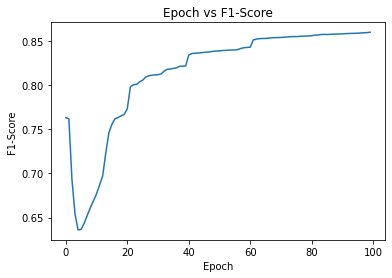


Train F1-Score 0.8598170876502991, Época:100

Train F1-Score 0.8593680262565613, Época:99

Train F1-Score 0.8592443466186523, Época:98

Train F1-Score 0.8589525818824768, Época:97

Train F1-Score 0.8587722778320312, Época:96


Validation F1-Score 0.8507095575332642, Época:100

Validation F1-Score 0.8500707745552063, Época:98

Validation F1-Score 0.8499060869216919, Época:94

Validation F1-Score 0.8498702049255371, Época:92

Validation F1-Score 0.8497339487075806, Época:97



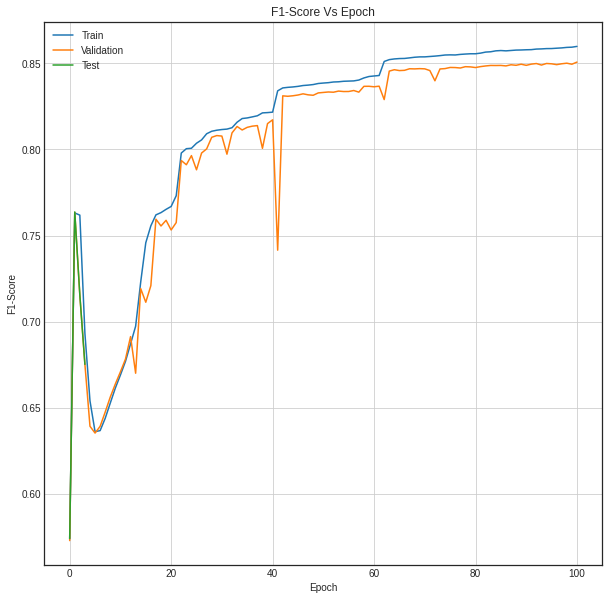

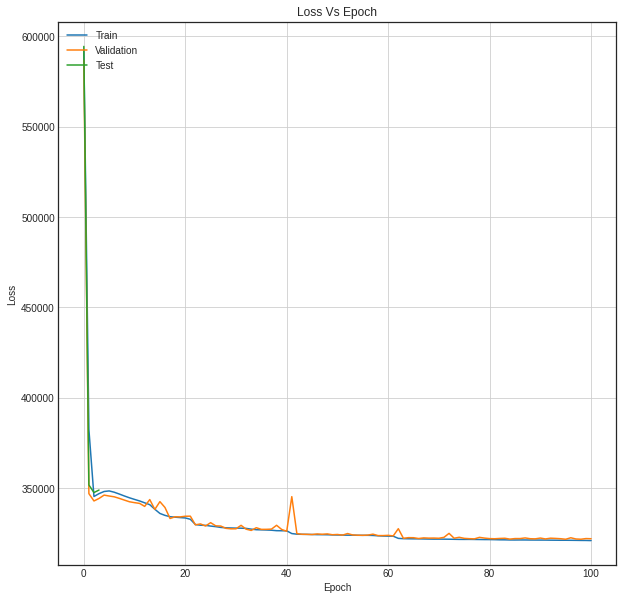

In [17]:
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

In [19]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, Y_dev, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])

ResourceExhaustedError:  OOM when allocating tensor with shape[29450,3000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node dense/kernel/Regularizer/Abs (defined at <ipython-input-12-cc5b1df7d9f0>:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_855]

Function call stack:
test_function
